<a href="https://colab.research.google.com/github/kunalvasudevan/AIML_PROJECT/blob/master/GermantoEnglish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Internship Project
#Language Translation(German to English)

#Problem Statement:
The objective of the project is to implement language
translation model aka machine translation for converting
German to English (and vice versa)
For this, the data is a text file (.txt) of English-German sentence
pairs. The actual data contains over 150,000 sentence-pairs.
However, it is suggested to use only the first 50,000 sentence
pairs to reduce the training time of the model.

You can download the Data set from

http://www.manythings.org/anki/

#Text Pre-Processing
Quite an important step in any project, especially so in NLP.
The data we work with is more often than not unstructured so
there are certain things we need to take care of before jumping
to the model building part.

(a) Text Cleaning

(b) Text to Sequence Conversion

A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

In [3]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import models    
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth',200)

In [4]:
#function to read raw text file
def read_text(filename):
  #open the file
  file = open(filename, mode='rt', encoding = 'utf-8')
  #read all text
  text = file.read()
  file.close()
  return text

In [5]:
#split a text into sentences
def to_lines(text):
  sents = text.strip().split('\n')
  sents= [i.split('\t')for i in sents]
  return sents

In [6]:
data = read_text("/content/deuuu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng = deu_eng[:50000,:]

In [8]:
#let's take a look at our data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom and Mary already know each other.',
        'Tom und Maria kennen einander bereits.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2955693 (CK) & #5080236 (Pfirsichbaeumchen)'],
       ['Tom and Mary already know each other.',
        'Tom und Maria kennen sich bereits.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2955693 (CK) & #7586699 (wolfgangth)'],
       ['Tom and Mary always tease each other.',
        'Tom und Maria necken sich immer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #8285232 (Hybrid) & #8285234 (Pfirsichbaeumchen)']],
      dtype='<U110')

In [9]:
# empty lists
eng_1=[]
deu_1=[]
# populate the list with sentence lengths
for i in deu_eng[:,0]:
  eng_1.append(len(i.split()))
  
for i in deu_eng[:,1]:
    deu_1.append(len(i.split()))

In [10]:
length_df = pd.DataFrame({'eng':eng_1, 'deu':deu_1})

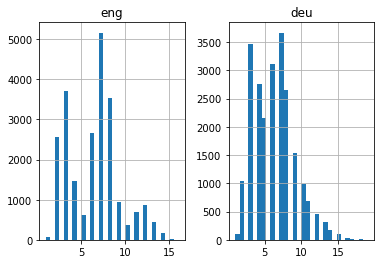

In [11]:
length_df.hist(bins=30)
plt.show()

In [12]:
# Function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [13]:
#preare english tokenizer
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index)+1

eng_length = 8
print('English Vocabulary Size: %d'% eng_vocab_size)

English Vocabulary Size: 6935


In [14]:
#prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index)+1

deu_length = 8
print('Deutch Vocabulary Size: %d'% deu_vocab_size)

Deutch Vocabulary Size: 11560


In [15]:
#encode and pad sequence
def encode_sequences(tokenizer, length, lines):
  #integer encode sequence
  seq = tokenizer.texts_to_sequences(lines)
  #pad sequence with 0 values
  seq = pad_sequences(seq, maxlen = length, padding='post')
  return seq

In [16]:
from sklearn.model_selection import train_test_split
train, test  = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [17]:
#prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:,0])

In [18]:
#prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, train[:,0])

In [19]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [20]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
#model.compile(loss='sparse_categorial_crossentropy', optimizers=rms)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=None)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
filename = 'model.Kunal'
Checkpoint = ModelCheckpoint(filename, monitor= 'val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                   epochs=5, batch_size=512,
                   validation_split = 0.5,
                   callbacks=[Checkpoint], verbose=1)

Epoch 1/5
19/19 [==============================] - 33s 307ms/step - loss: 6.8425 - val_loss: 4.9915

Epoch 00001: val_loss improved from inf to 4.99149, saving model to model.Kunal


INFO:tensorflow:Assets written to: model.Kunal/assets


INFO:tensorflow:Assets written to: model.Kunal/assets


Epoch 2/5
19/19 [==============================] - 4s 189ms/step - loss: 4.8591 - val_loss: 4.8347

Epoch 00002: val_loss improved from 4.99149 to 4.83471, saving model to model.Kunal


INFO:tensorflow:Assets written to: model.Kunal/assets


INFO:tensorflow:Assets written to: model.Kunal/assets


Epoch 3/5
19/19 [==============================] - 4s 188ms/step - loss: 4.7172 - val_loss: 4.7831

Epoch 00003: val_loss improved from 4.83471 to 4.78306, saving model to model.Kunal


INFO:tensorflow:Assets written to: model.Kunal/assets


INFO:tensorflow:Assets written to: model.Kunal/assets


Epoch 4/5
19/19 [==============================] - 4s 189ms/step - loss: 4.6311 - val_loss: 4.7652

Epoch 00004: val_loss improved from 4.78306 to 4.76517, saving model to model.Kunal


INFO:tensorflow:Assets written to: model.Kunal/assets


INFO:tensorflow:Assets written to: model.Kunal/assets


Epoch 5/5
19/19 [==============================] - 3s 186ms/step - loss: 4.5827 - val_loss: 4.7524

Epoch 00005: val_loss improved from 4.76517 to 4.75242, saving model to model.Kunal


INFO:tensorflow:Assets written to: model.Kunal/assets


INFO:tensorflow:Assets written to: model.Kunal/assets


#Acurracy Rate is 4.5827 where as loss is 4.7524

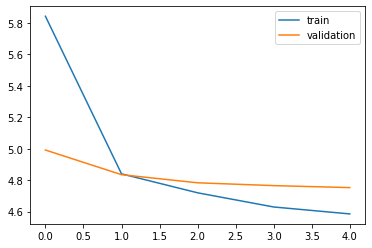

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [23]:
model = load_model('model.Kunal')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [24]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
      return None

In [25]:
#convert predictions into text (english)
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t=get_word(i[j], eng_tokenizer)
    if j>0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t== None):
        temp.append('')
      else:
        temp.append(t)
          
    else:
      if(t==None):
        temp.append('')
      else:
        temp.append(t)

        preds_text.append(''.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual': test[:,0], 'predicted': preds_text})

In [ ]:
pd.set_option('display.max_clowidth', 200)